In [1]:
%reset

import numpy as np
from sklearn import preprocessing
import math
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from numpy import *


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, Masking


from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

import seaborn as sns
from pylab import rcParams

from numpy.linalg import *
import math
from datetime import datetime
from datetime import timedelta


import tensorflow as tf
from tensorflow import keras
import os
import keras


os.environ["CUDA_VISIBLE_DEVICES"]='0'

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
# do stuff


%matplotlib inline



Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Using TensorFlow backend.
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/jupyterhub/anaconda/lib/python3.6/site-packag

In [2]:
# Import the data and making a dataframe out of it
df_deli = pd.read_csv('../Emilio Caba/Data/Delivery.csv')
df_cons = pd.read_csv('../Emilio Caba/Data/Consumption.csv')
df_info = pd.read_csv('../Emilio Caba/Data/Information.csv')
df_weather = pd.read_csv('../Data/KNMI_Voorschoten_20170711_20190601.csv')

# Setting indexes
df_deli.set_index('ID-nummer',inplace=True)
df_deli.index = pd.to_datetime(df_deli.index)
df_deli.index.names = ['date']

df_cons.set_index('ID-nummer',inplace=True)
df_cons.index = pd.to_datetime(df_cons.index)
df_cons.index.names = ['date']

df_info.set_index('ID-nummer',inplace=True)
df_info.index.names = ['date']

df_weather.set_index('Date_and_time',inplace=True)
df_weather = df_weather.loc['2017-09-12':'2019-06-01 00:00:00']
df_weather.index = pd.to_datetime(df_weather.index)
df_weather.index.names = ['date']
df_weather = df_weather.apply(pd.to_numeric)

# Creating first row to datasets
top_row = [0 for col in df_deli.columns]
df_top_row = pd.DataFrame(top_row).transpose()

s_top_row = pd.Series([pd.to_datetime('2017-09-12 00:00:00')])
df_top_row.set_index(s_top_row, inplace=True)
df_top_row.columns = df_deli.columns

# Adding first row to the datasets
df_deli = pd.concat([df_top_row, df_deli])
df_cons = pd.concat([df_top_row, df_cons])

# Joining datasets
df_deli = df_deli.join(df_weather)
df_cons = df_cons.join(df_weather)

# Filling NaN temperature values with the previous ones
df_deli.fillna(method='ffill', inplace=True)
df_cons.fillna(method='ffill', inplace=True)

# Deleting first row (dummy row)
df_deli = df_deli.iloc[1:]
df_cons = df_cons.iloc[1:]

display(df_deli.head(2))
display(df_deli.shape)
display(df_cons.head(2))
display(df_cons.shape)



df_deli = df_deli.iloc[:-5]
df_cons = df_cons.iloc[:-5]


,H01,H02,H03,H04,H06,H07,H08,H09,H11,H13,...,H27,H28,H29,H31,H32,H33,T,SQ,Q,N
2017-09-12 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0


(54745, 32)

,H01,H02,H03,H04,H06,H07,H08,H09,H11,H13,...,H27,H28,H29,H31,H32,H33,T,SQ,Q,N
2017-09-12 00:15:00,0.031,0.048,0.027,0.017,0.074,0.012,0.023,0.055,0.075,0.131,...,0.096,0.025,0.024,0.299,0.027,0.022,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.037,0.023,0.034,0.015,0.069,0.024,0.020,0.036,0.071,0.088,...,0.152,0.018,0.028,0.325,0.021,0.042,14.8,0.0,0.0,7.0


(54745, 32)

In [3]:
from datetime import date, datetime

def get_season(year_day):
    spring = range(80, 172) # Corresponds to season 1
    summer = range(172, 264) # Corresponds to season 2
    fall = range(264, 355) # Corresponds to season 3
    # winter Corresponds to season 4

    if year_day in spring:
        season = 1
    elif year_day in summer:
        season = 2
    elif year_day in fall:
        season = 3
    else:
        season = 4
    return season

In [4]:
df_deli = df_deli[['H01','H02','H06','H07','H08','H15','H16','H17','H18','H23','H20','H22','H25','H28','H32','T','SQ','Q','N']]
df_cons = df_cons[['H01','H02','H06','H07','H08','H15','H16','H17','H18','H23','H20','H22','H25','H28','H32','T','SQ','Q','N']]
df_info = df_info[['H01','H02','H06','H07','H08','H15','H16','H17','H18','H23','H20','H22','H25','H28','H32']]

display(df_deli)
display(df_cons)
display(df_info)

,H01,H02,H06,H07,H08,H15,H16,H17,H18,H23,H20,H22,H25,H28,H32,T,SQ,Q,N
2017-09-12 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.6,0.0,0.0,6.0
2017-09-12 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.6,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31 21:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,2.0
2019-05-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,8.0
2019-05-31 22:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,8.0
2019-05-31 22:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,8.0


,H01,H02,H06,H07,H08,H15,H16,H17,H18,H23,H20,H22,H25,H28,H32,T,SQ,Q,N
2017-09-12 00:15:00,0.031,0.048,0.074,0.012,0.023,0.033,0.396,0.122,0.069,0.044,0.029,0.038,0.021,0.025,0.027,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.037,0.023,0.069,0.024,0.020,0.033,0.331,0.053,0.059,0.033,0.017,0.034,0.025,0.018,0.021,14.8,0.0,0.0,7.0
2017-09-12 00:45:00,0.034,0.017,0.073,0.020,0.011,0.028,0.062,0.048,0.071,0.038,0.016,0.019,0.025,0.022,0.029,14.8,0.0,0.0,7.0
2017-09-12 01:00:00,0.296,0.023,0.066,0.019,0.012,0.028,0.053,0.052,0.546,0.038,0.023,0.015,0.025,0.019,0.029,14.6,0.0,0.0,6.0
2017-09-12 01:15:00,0.311,0.018,0.059,0.012,0.016,0.193,0.069,0.168,0.057,0.207,0.023,0.033,0.024,0.021,0.022,14.6,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31 21:45:00,0.020,0.050,0.016,0.022,0.035,0.030,0.064,0.106,0.082,0.047,0.036,0.094,0.016,0.116,0.022,13.1,0.0,0.0,2.0
2019-05-31 22:00:00,0.030,0.069,0.233,0.035,0.036,0.033,0.091,0.074,0.086,0.070,0.041,0.242,0.017,0.016,0.017,13.1,0.0,0.0,8.0
2019-05-31 22:15:00,0.043,0.056,0.074,0.070,0.057,0.027,0.104,0.056,0.090,0.084,0.041,0.255,0.018,0.019,0.020,13.1,0.0,0.0,8.0
2019-05-31 22:30:00,0.415,0.059,0.044,0.422,0.062,0.040,0.103,0.069,0.090,0.088,0.038,0.071,0.015,0.019,0.085,13.1,0.0,0.0,8.0


,H01,H02,H06,H07,H08,H15,H16,H17,H18,H23,H20,H22,H25,H28,H32
date,,,,,,,,,,,,,,,
concept,E,E,E,E,E,WP,WP,WP,WP,WP,Zon,Zon,Zon,Zon,Zon
PV-aantal,17,14,14,13,9,9,11,8,11,11,10,12,13,13,12
personen,4,2,4,2,4,1,4,4,4,2,2,4,2,2,4


In [5]:
# Setting dummy variables

df_deli['season'] = [get_season(index.timetuple().tm_yday) for index in df_deli.index]
df_cons['season'] = [get_season(index.timetuple().tm_yday) for index in df_cons.index]

df_deli['month'] = df_deli.index.month
df_cons['month'] = df_cons.index.month

df_deli['week'] = df_deli.index.week
df_cons['week'] = df_cons.index.week

df_deli['day'] = df_deli.index.day
df_cons['day'] = df_cons.index.day

#df_deli['day'] = df_deli.index.dayofweek
#df_cons['day'] = df_cons.index.dayofweek

df_deli['hour'] = df_deli.index.hour
df_cons['hour'] = df_cons.index.hour




df_deli['hour'].unique()


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [6]:
# Setting different columns (delivery, consumption, houses_info, dummy_variables)
df = pd.DataFrame(columns=['delivery','consumption', 'T', 'SQ', 'Q', 'N','heating_sys','week','month','season','day','hour'])

num_houses_cols = 15
#num_houses_cols = 28
# Preparing the delivery and consumption arrays
ar_deli = np.array([])
ar_cons = np.array([])
for col in range(num_houses_cols):
    ar_deli = np.append(ar_deli, df_deli.values[:, col])
    ar_cons = np.append(ar_cons, df_cons.values[:, col])

# Preparing the houses information arrays
ar_heatSystem = np.array([])
for col in df_info.columns:
    ar_heatSystem = np.append(ar_heatSystem, (df_info.loc[['concept'], [col]].values[0].tolist() * df_deli.shape[0]))

# Inserting the data to the dataframe
df['delivery'] = pd.Series(ar_deli)
df['consumption'] = pd.Series(ar_cons)

df['T'] = df_deli['T'].values.tolist() * num_houses_cols
df['SQ'] = df_deli['SQ'].values.tolist() * num_houses_cols
df['Q'] = df_deli['Q'].values.tolist() * num_houses_cols
df['N'] = df_deli['N'].values.tolist() * num_houses_cols

df['month'] = df_deli['month'].values.tolist() * num_houses_cols
df['week'] = df_deli['week'].values.tolist() * num_houses_cols
df['season'] = df_deli['season'].values.tolist() * num_houses_cols
df['day'] = df_deli['day'].values.tolist() * num_houses_cols
df['hour'] = df_deli['hour'].values.tolist() * num_houses_cols

df['heating_sys'] = pd.Series(ar_heatSystem)

# Replacing heating system type by numbers
df.replace('E', 1, inplace=True)
df.replace('WP', 2, inplace=True)
df.replace('Zon', 3, inplace=True)

display(df.head())
display(df.shape)




,delivery,consumption,T,SQ,Q,N,heating_sys,week,month,season,day,hour
0,0.0,0.031,14.8,0.0,0.0,7.0,1,37,9,2,12,0
1,0.0,0.037,14.8,0.0,0.0,7.0,1,37,9,2,12,0
2,0.0,0.034,14.8,0.0,0.0,7.0,1,37,9,2,12,0
3,0.0,0.296,14.6,0.0,0.0,6.0,1,37,9,2,12,1
4,0.0,0.311,14.6,0.0,0.0,6.0,1,37,9,2,12,1


(821100, 12)

In [7]:
del_heat = df[['delivery','consumption','T','SQ','Q','week','month','season','day','hour']] #storing only the columns that i want to use to train, (all of them except the target variable)


del_heat.head()

,delivery,consumption,T,SQ,Q,week,month,season,day,hour
0,0.0,0.031,14.8,0.0,0.0,37,9,2,12,0
1,0.0,0.037,14.8,0.0,0.0,37,9,2,12,0
2,0.0,0.034,14.8,0.0,0.0,37,9,2,12,0
3,0.0,0.296,14.6,0.0,0.0,37,9,2,12,1
4,0.0,0.311,14.6,0.0,0.0,37,9,2,12,1


In [8]:
#del_heat['day'] = del_heat['day'].astype(int)
#del_heat['hour'] = del_heat['hour'].astype(int)


In [9]:
x = del_heat.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled)

df_norm

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.011896,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
1,0.0,0.014198,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
2,0.0,0.013047,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
3,0.0,0.113584,0.538824,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.043478
4,0.0,0.119340,0.538824,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.043478
...,...,...,...,...,...,...,...,...,...,...
821095,0.0,0.008442,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.913043
821096,0.0,0.006523,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.956522
821097,0.0,0.007675,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.956522
821098,0.0,0.032617,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.956522


In [10]:
total = df_norm.values #array converting from the normalized dataframe 


In [11]:
#This code automatically calculates the best numbers for the reshape method

#divisions = [] 
#difference = np.inf
#day = 2 #Select the number of days you want to make your predictions on 
#
#for i in range(df_norm.shape[0]):
#    if (df_norm.shape[0] % (i+1) == 0):
#        divisions.append(i+1)
#        diff = abs((96*day)-(i+1))
#        if difference > diff:
#            difference = diff
#            rows = i+1
#        else:
#            pass
#        
#rows = 170      
#samples = int(df_norm.shape[0] / rows)

In [12]:
#170 rows and 4830 samples gives good results
rows = 92 
samples = 8925 
df_arr = df_norm.values
a2 = df_arr.reshape(samples,rows,df_norm.shape[1]) #1275 samples #644rows per house #10features per house 
a2.shape

(8925, 92, 10)

In [13]:
labeled_out = np.zeros((df['heating_sys'].shape[0], 3))

for i in range(len(df['heating_sys'])):
    if df['heating_sys'][i] == 1:
        labeled_out[i] = [1,0,0]
    elif df['heating_sys'][i] == 2:
        labeled_out[i] = [0,1,0]
    else:
        labeled_out[i] = [0,0,1]
        
labeled_out.shape

(821100, 3)

In [14]:
a2_out = labeled_out.reshape(samples,rows,labeled_out.shape[1]) #1275 samples #644rows per house #3features per house 
a2_out.shape

(8925, 92, 3)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(a2,a2_out, test_size=0.3) #splitin the 30% of the data to test



In [16]:
model = Sequential()


In [17]:
X_train.shape[2]

10

In [18]:
#
n_features = X_train.shape[2]   #X_train.shape[1]
timesteps = X_train.shape[1]   #1


# Recurrent layer
#model.add(LSTM(30, input_shape=(timesteps, n_features), dropout=0.2, recurrent_dropout=0.1, return_sequences=True))

model.add(LSTM(40, input_shape=(timesteps, n_features), dropout=0.2, recurrent_dropout=0.1, return_sequences=True)) #96.1% with 20 Dense relu en 0.25 dropout

# Fully connected layer
model.add(Dense(20, activation='relu'))#relu/linear
model.add(Dropout(0.25))

# Output layer
model.add(Dense(3, activation='softmax'))#softmax/softmax para cada tipo de neurona




In [19]:
lr= 0.003 #lr= 0.01 25 epochs got 75% validation accuracy and 96% fonal accuracy
            #0.03 25 epochs got 35% validation accuracy and 36% final accuracy

model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(lr), metrics = ['accuracy'])#loss = mean_squared_error


In [20]:
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

#X_test = np.reshape(X_test, (X_test.shape[0], 1 ,X_test.shape[1]))



In [21]:

Y_train = Y_train.astype(int)

In [22]:

history = model.fit(X_train, Y_train,validation_split = 0.2,  epochs = 60) #storing in the history variable to plot it after (loss and accuracy)


Train on 4997 samples, validate on 1250 samples
Epoch 1/60
4997/4997 [==============================] - 19s 4ms/step - loss: 0.2227 - acc: 0.3394 - val_loss: 0.2214 - val_acc: 0.3397
Epoch 2/60
4997/4997 [==============================] - 16s 3ms/step - loss: 0.2206 - acc: 0.3598 - val_loss: 0.2196 - val_acc: 0.3729
Epoch 3/60
4997/4997 [==============================] - 16s 3ms/step - loss: 0.2184 - acc: 0.3794 - val_loss: 0.2149 - val_acc: 0.4061
Epoch 4/60
4997/4997 [==============================] - 16s 3ms/step - loss: 0.2153 - acc: 0.4108 - val_loss: 0.2079 - val_acc: 0.4807
Epoch 5/60
4997/4997 [==============================] - 16s 3ms/step - loss: 0.2091 - acc: 0.4496 - val_loss: 0.1973 - val_acc: 0.5382
Epoch 6/60
4997/4997 [==============================] - 16s 3ms/step - loss: 0.2100 - acc: 0.4591 - val_loss: 0.2105 - val_acc: 0.4307
Epoch 7/60
4997/4997 [==============================] - 17s 3ms/step - loss: 0.2084 - acc: 0.4542 - val_loss: 0.1857 - val_acc: 0.5655
Epoch 8

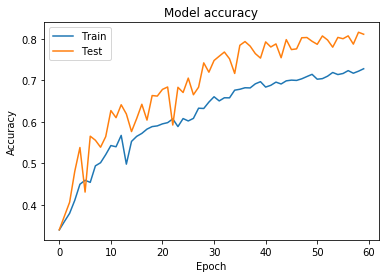

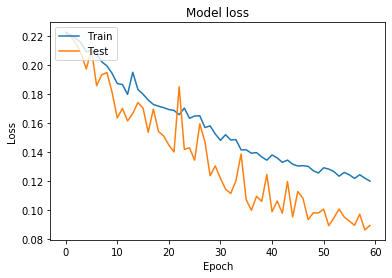

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")

In [24]:
#model.load_weights("model_SP_79.h5")

X_predict = model.predict(X_test)

In [25]:
X_test[0][1]

array([0.03732162, 0.        , 0.49647059, 0.        , 0.0119403 ,
       0.37254902, 0.36363636, 0.        , 0.63333333, 0.86956522])

In [26]:
X_predict_round = X_predict

for i in range(len(X_predict_round)):
    if X_predict_round[i][rows-1][0] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [1,0,0]
    elif X_predict_round[i][rows-1][1] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,1,0]
    elif X_predict_round[i][rows-1][2] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,0,1]
        
#X_predict_round = X_predict_round /100

In [27]:
X_predict[71]

array([[2.81018883e-01, 3.67440522e-01, 3.51540625e-01],
       [2.71638751e-01, 4.22738314e-01, 3.05622876e-01],
       [2.82330334e-01, 5.32915473e-01, 1.84754133e-01],
       [2.09159300e-01, 6.86692715e-01, 1.04147986e-01],
       [1.52562246e-01, 7.40361571e-01, 1.07076220e-01],
       [1.68260530e-01, 7.11342037e-01, 1.20397389e-01],
       [1.91893503e-01, 6.44545019e-01, 1.63561538e-01],
       [1.92169443e-01, 5.60992897e-01, 2.46837661e-01],
       [2.07578734e-01, 5.09048998e-01, 2.83372223e-01],
       [1.98779881e-01, 4.79200125e-01, 3.22020024e-01],
       [1.93948403e-01, 5.03616750e-01, 3.02434832e-01],
       [1.71040565e-01, 5.12354732e-01, 3.16604674e-01],
       [1.67579249e-01, 5.13731062e-01, 3.18689644e-01],
       [1.65316477e-01, 5.12717247e-01, 3.21966231e-01],
       [1.57710940e-01, 5.00779152e-01, 3.41509908e-01],
       [1.58387691e-01, 4.95536000e-01, 3.46076339e-01],
       [1.54436901e-01, 5.26788950e-01, 3.18774164e-01],
       [1.34865716e-01, 6.40764

In [28]:
Y_test[71]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1

In [29]:

accuracy = np.empty(len(Y_test))

for i in range(len(X_predict_round)):
    if np.array_equal(X_predict_round[i][rows-1], Y_test[i][rows-1]):
        accuracy[i] = True
    else:
        accuracy[i] = False
 
print('the final accuracy is: ' + str(round(np.mean(accuracy)*100,1)) + '%')

the final accuracy is: 94.6%


In [30]:
Y_test.shape[0]

2678

In [31]:
Y_test = Y_test.astype(int)
X_predict_round[0][rows-1]

array([1., 0., 0.], dtype=float32)

In [32]:

Y_real = np.zeros([Y_test.shape[0]])

for i in range(Y_test.shape[0]):
    if np.array_equal(Y_test[i][rows-1], [1,0,0]):
        Y_real[i] = 1

    elif np.array_equal(Y_test[i][rows-1], [0,1,0]):
        Y_real[i] = 2

    else:
        Y_real[i] = 3
      


In [33]:
X_predicted = np.zeros([X_predict_round.shape[0]])
    
    
for i in range(X_predict_round.shape[0]):
    if np.array_equal(X_predict_round[i][rows-1], [1,0,0]):
        X_predicted[i] = 1

    elif np.array_equal(X_predict_round[i][rows-1], [0,1,0]):
        X_predicted[i] = 2

    else:
        X_predicted[i] = 3


In [34]:
X_predicted_flatten = X_predicted.ravel()
print(X_predicted_flatten)

Y_real_flatten = Y_real.ravel()
print(Y_real_flatten)




[1. 3. 3. ... 1. 1. 2.]
[1. 3. 3. ... 1. 1. 2.]


[[887  16  50]
 [  4 841  30]
 [ 40   4 806]]


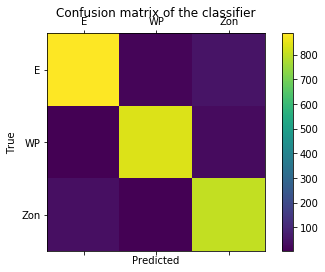


              precision    recall  f1-score   support

         1.0       0.95      0.93      0.94       953
         2.0       0.98      0.96      0.97       875
         3.0       0.91      0.95      0.93       850

   micro avg       0.95      0.95      0.95      2678
   macro avg       0.95      0.95      0.95      2678
weighted avg       0.95      0.95      0.95      2678



In [35]:


from sklearn.metrics import confusion_matrix

y_test = Y_real_flatten #* 10 #multiply to 10 to avoid the decimals (the confusion matrix get integers)

pred = X_predicted_flatten#*10 #multiply to 10 to avoid the decimals (the confusion matrix get integers)

labels = [1, 2, 3] #the 3 labels we want to find (remember thereare the normalized data * 10)
cm = confusion_matrix(y_test, pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + ['E', 'WP', 'Zon'])
ax.set_yticklabels([''] + ['E', 'WP', 'Zon'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

print()

print(classification_report(y_test, pred))

#model.save_weights("modelHS.h5")
#print("Saved model to disk")

In [ ]:
c = [[887,16,  50]
 [  4, 841,  30]
 [ 40,   4, 806]]
for i in range(len(c)):
    for j in range(len(c[0])):
        if i==j:
            true_positives+= c[i][j]
        else:
            

In [36]:
!nvidia-smi


Sun Dec  8 18:50:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M10           Off  | 00000000:DA:00.0 Off |                  N/A |
| N/A   43C    P0    18W /  53W |    396MiB /  8127MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M10           Off  | 00000000:DB:00.0 Off |                  N/A |
| N/A   36C    P0    16W /  53W |   7792MiB /  8127MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T